# 03 - Training Model

The third notebook is pivotal to the project, encompassing the comprehensive process of model training. It covers several critical steps:

- Data Preprocessing and DataLoader: Initial steps involve preprocessing the EuroSAT dataset and setting up PyTorch DataLoaders. This preparation is essential for efficient model training and validation.

- Visualization of Data: Before diving into training, the notebook presents the data visually, aiding in understanding the dataset's composition and ensuring that the preprocessing steps have been successfully applied.

- Model Initialization: Leveraging the previously defined neural network structure, the model is initialized and prepared for training.

- Loss Function and Optimizer: The Cross-Entropy Loss function is selected for evaluating model performance, combined with the Adam optimizer for adjusting model weights based on the loss gradient.

- Model Training and Evaluation: The notebook meticulously documents the training process, including monitoring loss reduction over epochs and evaluating the model's accuracy on the test set.

- Model Saving: Concluding the training phase, the successfully trained model is saved for future use, facilitating deployment and further evaluations.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import cuda
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from mypackages.landneuralnetwork import LandClassifierNet


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Destination folders for training and testing image groups
train_images_folder = "../data/train_imgs"
test_images_folder = "../data/test_imgs"

In [3]:
# Check the GPU model
if torch.cuda.is_available():
    print('Number of GPUs:', torch.cuda.device_count())
    print('GPU Model:', torch.cuda.get_device_name(0))
    print('Total GPU Memory [GB]:', torch.cuda.get_device_properties(0).total_memory / 1e9)

Number of GPUs: 1
GPU Model: Quadro RTX 3000
Total GPU Memory [GB]: 6.442123264


In [4]:
# Reset GPU memory
device = cuda.get_current_device()
device.reset()

# Pre processing and create Dataloaders

In [5]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),   
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**transforms.Compose([...]):** This method is used to chain or compose multiple image transformations together. It takes a list of transformations and applies them in sequence.

**transforms.ToTensor():** This transformation converts PIL images or numpy arrays into PyTorch tensors. It also automatically scales the image data to the range [0, 1].

**transforms.Normalize(mean, std):** This transformation normalizes a tensor image with a specified mean and standard deviation for each channel (Each color channel (Red, Green, Blue) is normalized)

-  The first tuple (0.5, 0.5, 0.5) represents the mean for each channel to be subtracted.
-  The second tuple (0.5, 0.5, 0.5) represents the standard deviation for each channel to divide by.
- This normalization helps in speeding up the training and reduces the chances of getting stuck in local optima.

In [6]:
# Training dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_images_folder, transform = transform)

# Testing dataset
test_dataset = torchvision.datasets.ImageFolder(root = test_images_folder, transform = transform)

In [7]:
# Training Dataloader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)

# Testing Dataloader
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 2)

A DataLoader in the context of PyTorch is a powerful utility that abstracts away the complexity of fetching batches of data from a dataset, making it easier and more efficient to supply data to a neural network during training or evaluation.

**batch_size:** Specifies the number of data points to be included in each batch. Here, it is set to 64, meaning that the DataLoader will yield batches containing 64 samples each time it is iterated over.

**shuffle:** Determines whether the data should be shuffled at the beginning of each epoch. Setting this to True ensures that the order of the data is randomized, which is beneficial for training models because it introduces randomness in the input data, helping to improve model generalization and reduce overfitting.

**num_workers:** Specifies the number of subprocesses to use for data loading. Here, it is set to 2, indicating that two parallel workers will be used to load data. This can improve the efficiency of data loading, especially when dealing with large datasets or performing computationally intensive preprocessing steps.

# Viewing the images

In [8]:
def imshow(img):
    """
    Displays a PyTorch Tensor as an image using matplotlib.

    The input tensor is expected to have the PyTorch shape `(C, H, W)` for a single image,
    or `(N, C, H, W)` for a batch of images, where:
    - `C` is the number of channels (3 for RGB, 1 for grayscale),
    - `H` is the height,
    - `W` is the width,
    - `N` is the batch size.

    The function undoes the normalization (assumed to be img = img / 2 + 0.5) and uses
    matplotlib to display the image.

    Parameters:
    - img (torch.Tensor): The image tensor to display.
    """

    # Undo the normalization of the image
    img = img / 2 + 0.5
    
    # Convert the tensor image to a numpy array.
    # The `.numpy()` method changes the tensor into a numpy array.
    npimg = img.numpy()
    
    # Display the image.
    # `np.transpose(npimg, (1, 2, 0))` changes the shape from `(C, H, W)` to `(H, W, C)`,
    # which is the shape expected by `plt.imshow`. This is necessary for correctly displaying
    # the image because matplotlib expects the color channel to be the last dimension.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  # Displays the figure.


In [9]:
# Gets a batch of images
dataiter = iter(train_dl)
images, labels = next(dataiter)

In [10]:
mapping = {0:'AnnualCrop',
              1:'Forest',
              2:'HerbaceousVegetation',
              3:'Highway',
              4:'Industrial',
              5:'Pasture',
              6:'PermanentCrop',
              7:'Residential',
              8:'River',
              9:'SeaLake'}

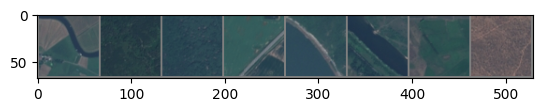

Labels: 8: River |  1: Forest |  1: Forest |  3: Highway |  3: Highway |  8: River |  5: Pasture |  2: HerbaceousVegetation | 


In [11]:
# View imagem
grid = torchvision.utils.make_grid(images[:8])
imshow(grid)

# Printing both label numbers and their corresponding names
print('Labels:', ' '.join('%d: %s | ' % (labels[j].item(), mapping[labels[j].item()]) for j in range(8)))

# Create model

In [12]:
nn_model = LandClassifierNet()

In [13]:
print(nn_model)

LandClassifierNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# Send model to device
nn_model.to(device)

LandClassifierNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()

**CrossEntropyLoss:** is a class from PyTorch's neural network module (torch.nn) that implements the cross-entropy loss function. Cross-entropy loss is commonly used in classification tasks, especially for multi-class classification problems. It combines nn.LogSoftmax() and nn.NLLLoss() (Negative Log Likelihood Loss) in one single class, making it convenient and efficient for training classification models. This loss function calculates the difference between the predicted probability distribution (output of the model) and the true distribution, where the true distribution is the distribution of the actual labels. This function is essential for training as it provides a measure of how well the model is performing; the lower the loss, the better the model's predictions.

In [17]:
# Optimizer
optimizer = optim.Adam(nn_model.parameters())

**Adam Optimizer:** is a class from PyTorch's optimization module (torch.optim) that implements the Adam optimization algorithm. Adam (Adaptive Moment Estimation) is a popular optimization algorithm used in training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. It's particularly effective in cases where the amount of data or the parameters of the model are large. During training, calling the .step() method on an Adam optimizer instance will update the model's parameters based on the gradients computed during the backward pass of the model.
Adam is known for being robust to the choice of hyperparameters, although the learning rate still needs to be set carefully. It's widely used for various kinds of deep learning tasks.

# Training

In [18]:
# Number of epochs
num_epochs = 30

# Test iteration
testiter = iter(test_dl)

In [19]:
%%time
print('Training Started!')

# Initializes a list to keep track of the average loss per epoch
epoch_losses = []

# Iterates over the number of epochs
for epoch in range(num_epochs):
    # Initializes the variable that accumulates the loss over the epoch
    running_loss = 0.0

    # Iterates over the training data with a progress bar (tqdm)
    for i, (inputs, labels) in enumerate(tqdm(train_dl, desc=f"Epoch {epoch}")):
        # Moves the inputs and labels to the correct device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zeroes the gradients of the optimizer
        optimizer.zero_grad()

        # Performs the forward pass through the neural network
        outputs = nn_model(inputs)

        # Calculates the loss using the defined criterion
        loss = criterion(outputs, labels)

        # Performs the backward pass to compute gradients
        loss.backward()

        # Updates the neural network's weights using the optimizer
        optimizer.step()

        # Updates the accumulated loss value
        running_loss += loss.item()

        # Periodically checks the model's performance on a subset of the test data
        if i % 100 == 0:  
            # Temporarily disables gradient calculations to save memory and computation time
            with torch.no_grad():
                # Gets a batch of test images and labels
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # Performs a forward pass on the neural network with a subset of test images
                test_outputs = nn_model(test_images[:8])

                # Gets the predictions for the subset of test images
                _, predicted = torch.max(test_outputs, 1)
                
    # Calculates the average loss for the current epoch and saves it
    epoch_loss = running_loss / len(train_dl)
    epoch_losses.append(epoch_loss)

    # Displays the average loss for the epoch
    print(f"Epoch {epoch}, Loss: {epoch_loss}")

print('Training Completed!')

Training Started!


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:23<00:00,  1.50s/it]


Epoch 0, Loss: 1.2579966143176362


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:04<00:00,  1.44s/it]


Epoch 1, Loss: 0.7230578895557571


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [06:58<00:00,  1.41s/it]


Epoch 2, Loss: 0.5305195250422567


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [06:57<00:00,  1.41s/it]


Epoch 3, Loss: 0.39538996309243346


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [06:54<00:00,  1.40s/it]


Epoch 4, Loss: 0.28149495160559546


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:15<00:00,  1.47s/it]


Epoch 5, Loss: 0.16463991287919516


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:22<00:00,  1.50s/it]


Epoch 6, Loss: 0.11757914260709407


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:26<00:00,  1.51s/it]


Epoch 7, Loss: 0.11119188819508496


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:14<00:00,  1.47s/it]


Epoch 8, Loss: 0.09704884681441645


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 296/296 [07:08<00:00,  1.45s/it]


Epoch 9, Loss: 0.09011164298548514


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:05<00:00,  1.44s/it]


Epoch 10, Loss: 0.06541000432578684


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:06<00:00,  1.44s/it]


Epoch 11, Loss: 0.08174132129470063


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [06:57<00:00,  1.41s/it]


Epoch 12, Loss: 0.06722346251213772


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:32<00:00,  1.53s/it]


Epoch 13, Loss: 0.04831355207765277


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [08:17<00:00,  1.68s/it]


Epoch 14, Loss: 0.047738114366979605


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [08:13<00:00,  1.67s/it]


Epoch 15, Loss: 0.049899521577400095


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [08:10<00:00,  1.66s/it]


Epoch 16, Loss: 0.05556863675028089


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [08:00<00:00,  1.62s/it]


Epoch 17, Loss: 0.05177364894306929


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:34<00:00,  1.53s/it]


Epoch 18, Loss: 0.05738307670791885


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:11<00:00,  1.46s/it]


Epoch 19, Loss: 0.028591035986283788


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:11<00:00,  1.46s/it]


Epoch 20, Loss: 0.052365137432856056


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:14<00:00,  1.47s/it]


Epoch 21, Loss: 0.03486906745476173


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:12<00:00,  1.46s/it]


Epoch 22, Loss: 0.04398340147747296


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:10<00:00,  1.46s/it]


Epoch 23, Loss: 0.03113279780877378


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:13<00:00,  1.47s/it]


Epoch 24, Loss: 0.034542104195483064


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:14<00:00,  1.47s/it]


Epoch 25, Loss: 0.02884197647373996


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:09<00:00,  1.45s/it]


Epoch 26, Loss: 0.06393253129612571


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:12<00:00,  1.46s/it]


Epoch 27, Loss: 0.041927948886164024


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:13<00:00,  1.47s/it]


Epoch 28, Loss: 0.03345404574947925


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 296/296 [07:15<00:00,  1.47s/it]

Epoch 29, Loss: 0.03242310561291112
Training Completed!
CPU times: total: 3h 5min 3s
Wall time: 3h 40min 5s


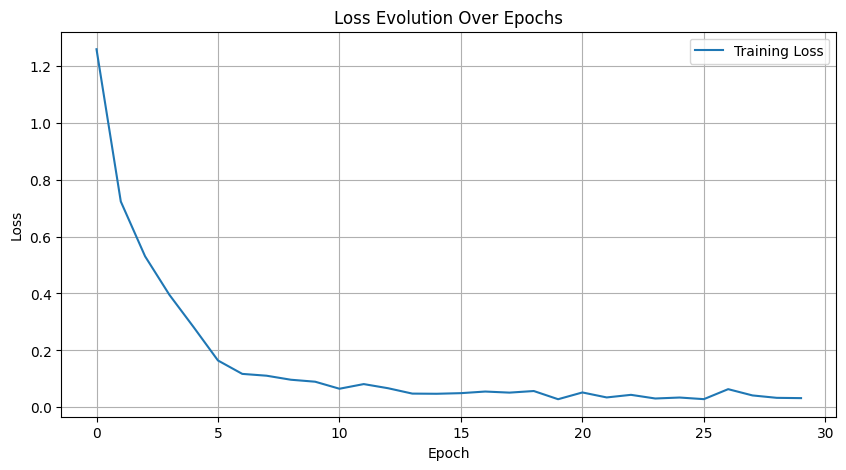

In [21]:
# Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Loss Evolution Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# Evaluation the model

In [22]:
# Puts the model in evaluation mode (this deactivates layers such as dropout and batch normalization)
nn_model.eval()

total_correct = 0
total_samples = 0

# Disables gradient calculation to save memory and processing time
with torch.no_grad():
    # Iterates over the test data with a progress bar (tqdm)
    for inputs, labels in tqdm(test_dl, desc="Evaluating Model"):
        
        # Moves the inputs and labels to the correct device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Performs a forward pass through the model
        outputs = nn_model(inputs)

        # Gets the predicted class (index of maximum value) for each input in the batch
        _, predicted = torch.max(outputs.data, 1)

        # Increments the total samples by the number of labels in the current batch
        total_samples += labels.size(0)

        # Increments the total correct predictions by the number of correct predictions in the current batch
        total_correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = (total_correct / total_samples) * 100
print(f'Accuracy: {accuracy:.2f}%')

Evaluating Model: 100%|███████████████████████████████████████████████████████████| 8100/8100 [01:19<00:00, 102.19it/s]

Accuracy: 82.21%


# Saving the model

In [23]:
torch.save(nn_model.state_dict(), 'nn_model.pth')